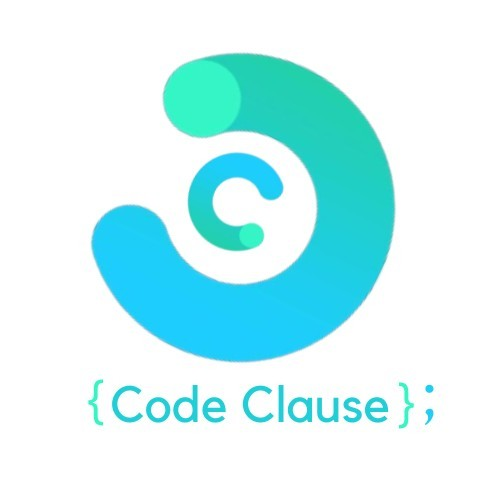

#**Price Recommendation for Online Sellers:**


NAME:G.HARINISRI




Product pricing gets even harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.

Mercari, Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.

In this Mercari’s challenging you to build an algorithm that automatically suggests the right product prices. You’ll be provided user-inputted text descriptions of their products, including details like product category name, brand name, and item condition.

**Dataset Features**
ID: the id of the listing

Name: the title of the listing

Item Condition: the condition of the items provided by the seller

Category Name: category of the listing

Brand Name: brand of the listing

Shipping: whether or not shipping cost was provided

Item Description: the full description of the item

Price: the price that the item was sold for. This is the target variable that you will predict. The unit is USD

IMPORT THE REQUIRED PACKAGES AND LIBRARIES


In [1]:
# Importing all the important Libraries
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from string import punctuation
# vstack - adds rows, hstack - adds columns
# csr_matrix - used to handle sparse matrix
from scipy.sparse import vstack, hstack, csr_matrix
# CountVectorizer - Simply, counts word frequencies 
# TFIDF - More importance/weights on "rare" words. Less importance/weights on "frequent" words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# LabelBinarizer - Converts labels into numerical representation "G,B,R" -> [1,2,3]
from sklearn.preprocessing import LabelBinarizer
# Ridge - Reduces multicollinearity in regression. Applies L2 Regularization
from sklearn.linear_model import Ridge

IMPORTING THE DATASET

In [2]:

# Create training set
train = pd.read_csv('/content/drive/MyDrive/CODECLAUSE INTERNSHIP/train.tsv', sep = '\t')
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
# Create testing set
test = pd.read_csv('/content/drive/MyDrive/CODECLAUSE INTERNSHIP/test.tsv', sep = '\t',engine = 'python')

In [4]:
# Create log price variable (Transformation)
y = np.log1p(train['price'])

COMBINE TRAIN AND TEST DATA

In [5]:
# Create combined set. You would want to apply count vectorizer on combined set so you can get the list of all possible words.
combined = pd.concat([train,test])

# Create the submission set (Only contains the test ID)
submission = test[['test_id']]

# Create size of train
train_size = len(train)

In [6]:
combined.shape

(2175894, 9)

In [7]:
combined_ML = combined.sample(frac=0.1).reset_index(drop=True)

In [8]:
combined_ML.shape

(217589, 9)

PREPROCESSING

In [9]:
# Create a list of punctuation replacements
punctuation_symbols = []
for symbol in punctuation:
    punctuation_symbols.append((symbol, ''))
    
punctuation_symbols

[('!', ''),
 ('"', ''),
 ('#', ''),
 ('$', ''),
 ('%', ''),
 ('&', ''),
 ("'", ''),
 ('(', ''),
 (')', ''),
 ('*', ''),
 ('+', ''),
 (',', ''),
 ('-', ''),
 ('.', ''),
 ('/', ''),
 (':', ''),
 (';', ''),
 ('<', ''),
 ('=', ''),
 ('>', ''),
 ('?', ''),
 ('@', ''),
 ('[', ''),
 ('\\', ''),
 (']', ''),
 ('^', ''),
 ('_', ''),
 ('`', ''),
 ('{', ''),
 ('|', ''),
 ('}', ''),
 ('~', '')]

In [10]:
import string
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

In [11]:
def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()])
    return x

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')

def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def to_lower(x):
    return x.lower()

EXPLORATORY DATA ANALYSIS

In [14]:
train.count()

train_id             1482535
name                 1482535
item_condition_id    1482535
category_name        1476208
brand_name            849853
price                1482535
shipping             1482535
item_description     1482531
dtype: int64

In [15]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [16]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [17]:
# Could we use these as features? Look at median price for each quantile
bins = [0, 10, 17, 29, 2001]
labels = ['q1','q2','q3','q4']
train['price_bin'] = pd.cut(train['price'], bins=bins, labels=labels)
train.groupby('price_bin')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
price_bin,,,,,,,,
q1,375615.0,7.715192,2.077888,3.0,6.0,8.0,10.0,10.0
q2,378177.0,13.842940,1.794584,10.5,12.0,14.0,15.0,17.0
q3,359743.0,22.555694,3.337832,17.5,20.0,22.0,25.0,29.0
q4,368123.0,63.527701,63.508250,29.5,35.0,45.0,66.0,2000.0


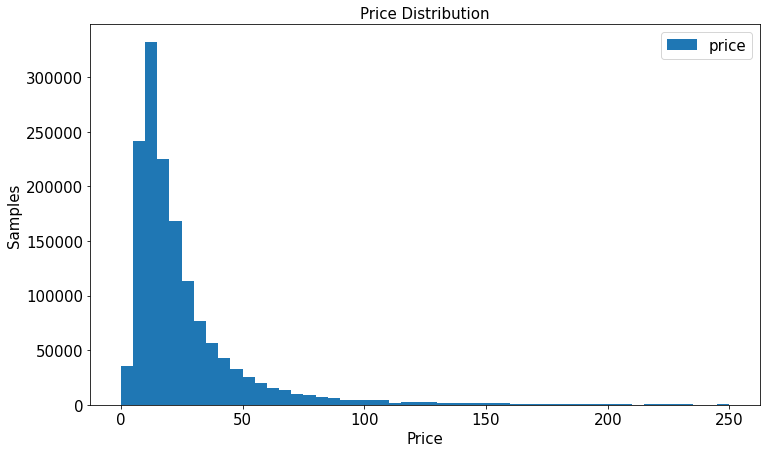

In [18]:
plt.figure(figsize=(12, 7))
plt.hist(train['price'], bins=50, range=[0,250], label='price')
plt.title('Price Distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

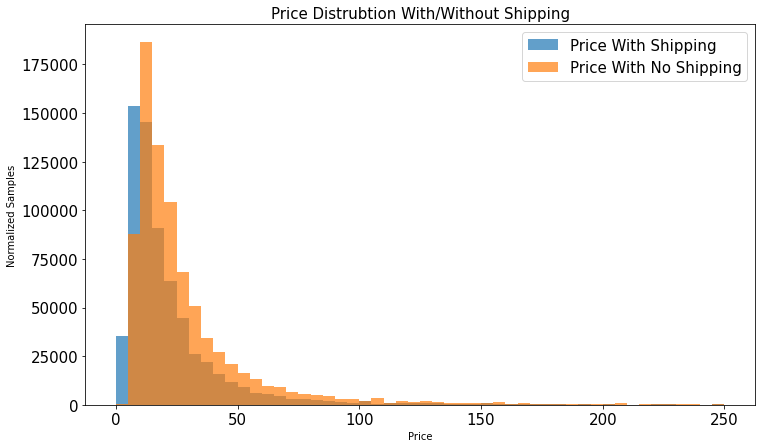

In [19]:
shipping = train[train['shipping']==1]['price']
no_shipping = train[train['shipping']==0]['price']

plt.figure(figsize=(12,7))
plt.hist(shipping, bins=50, range=[0,250], alpha=0.7, label='Price With Shipping')
plt.hist(no_shipping, bins=50, range=[0,250], alpha=0.7, label='Price With No Shipping')
plt.title('Price Distrubtion With/Without Shipping', fontsize=15)
plt.xlabel('Price')
plt.ylabel('Normalized Samples')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

BRAND ANALYSIS

In [20]:
# Amount of unique brand names
train['brand_name'].nunique()

4809

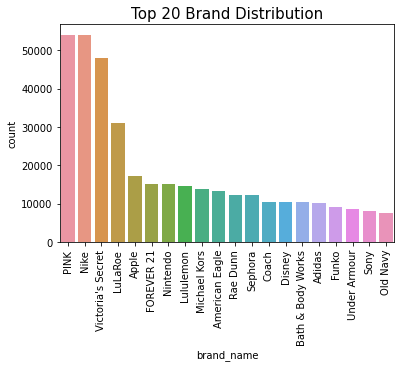

In [21]:
# Top 20 Brand Distribution
b20 = train['brand_name'].value_counts()[0:20].reset_index().rename(columns={'index': 'brand_name', 'brand_name':'count'})
ax = sns.barplot(x="brand_name", y="count", data=b20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Brand Distribution', fontsize=15)
plt.show()

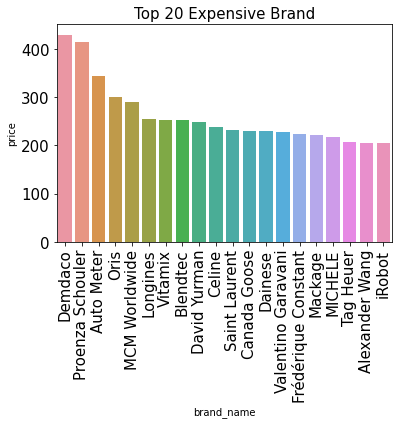

PINK                    0.063644
Nike                    0.063591
Victoria's Secret       0.056523
LuLaRoe                 0.036505
Apple                   0.020382
                          ...   
The Learning Journey    0.000001
Pampers Baby Fresh      0.000001
Huggies One & Done      0.000001
Classic Media           0.000001
Kids Only               0.000001
Name: brand_name, Length: 4809, dtype: float64

In [22]:
# Display Top 20 Expensive Brands By Mean Price
top20_brand = train.groupby('brand_name', axis=0).mean()
df_expPrice = pd.DataFrame(top20_brand.sort_values('price', ascending = False)['price'][0:20].reset_index())


ax = sns.barplot(x="brand_name", y="price", data=df_expPrice)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=15)
ax.set_title('Top 20 Expensive Brand', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()# Displayd frequency ratio of brand names
train['brand_name'].value_counts(1)

In [23]:
def transform_category_name(category_name):
    try:
        main, sub1, sub2= category_name.split('/')
        return main, sub1, sub2
    except:
        return np.nan, np.nan, np.nan

train['category_main'], train['category_sub1'], train['category_sub2'] = zip(*train['category_name'].apply(transform_category_name))

cat_train = train[['category_main','category_sub1','category_sub2', 'price']]

cat_train.head()

,category_main,category_sub1,category_sub2,price
0,Men,Tops,T-shirts,10.0
1,Electronics,Computers & Tablets,Components & Parts,52.0
2,Women,Tops & Blouses,Blouse,10.0
3,Home,Home Décor,Home Décor Accents,35.0
4,Women,Jewelry,Necklaces,44.0


In [24]:
# Electronics have the highest std
train.groupby('category_main')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
category_main,,,,,,,,
Beauty,207828.0,19.671536,21.360135,0.0,10.0,15.0,24.0,2000.0
Electronics,119631.0,34.191769,64.037637,0.0,9.0,15.0,30.0,1909.0
Handmade,30840.0,18.154410,27.756418,0.0,6.0,12.0,20.0,1750.0
Home,67871.0,24.536599,24.417061,0.0,12.0,18.0,29.0,848.0
Kids,171689.0,20.642315,22.730876,0.0,10.0,14.0,24.0,809.0
Men,93363.0,34.693347,41.264184,0.0,14.0,21.0,40.0,1309.0
Other,45351.0,20.809817,29.847758,0.0,9.0,14.0,23.0,1400.0
Sports & Outdoors,24331.0,25.534565,29.324018,0.0,11.0,16.0,28.0,915.0
Vintage & Collectibles,46530.0,27.339426,53.507495,0.0,10.0,16.0,27.0,1709.0


In [25]:
# Display distribution
train['category_main'].value_counts(1)

Women                     0.451404
Beauty                    0.141205
Kids                      0.116651
Electronics               0.081281
Men                       0.063434
Home                      0.046114
Vintage & Collectibles    0.031614
Other                     0.030813
Handmade                  0.020954
Sports & Outdoors         0.016531
Name: category_main, dtype: float64

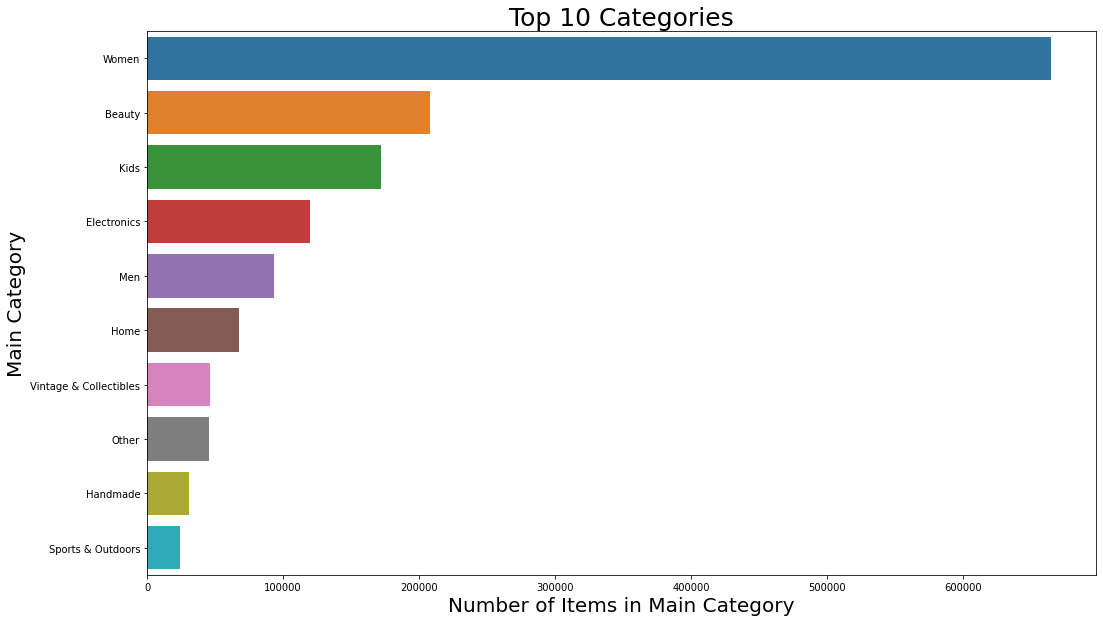

In [26]:
plt.figure(figsize=(17,10))
sns.countplot(y = train['category_main'], order = train['category_main'].value_counts().index, orient = 'v')
plt.title('Top 10 Categories', fontsize = 25)
plt.ylabel('Main Category', fontsize = 20)
plt.xlabel('Number of Items in Main Category', fontsize = 20)
plt.show()

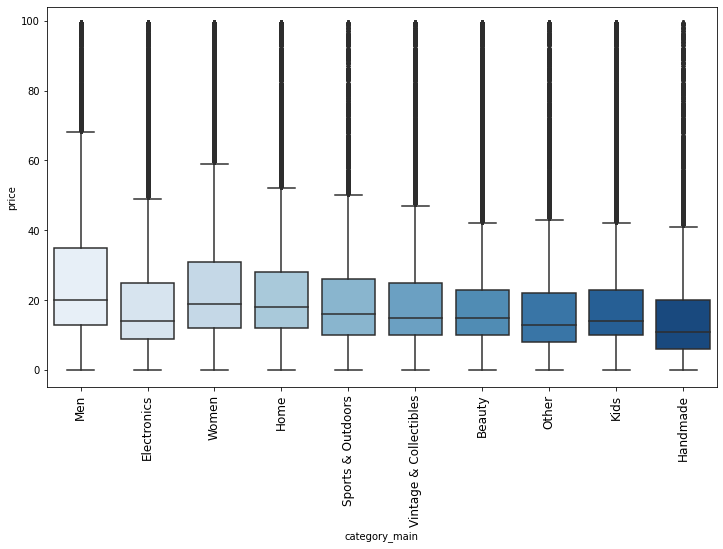

In [27]:
#main = pd.DataFrame(cat_train['category_main'].value_counts()).reset_index().rename(columns={'index': 'main', 'category_main':'count'})
fig, axes = plt.subplots(figsize=(12, 7))
main = cat_train[cat_train["price"]<100]
# Use a color palette
ax = sns.boxplot( x=main["category_main"], y=main["price"], palette="Blues")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=12)

plt.show()

In [28]:
# Create a "no_brand" column 
train['no_brand'] = train['brand_name'].isnull()

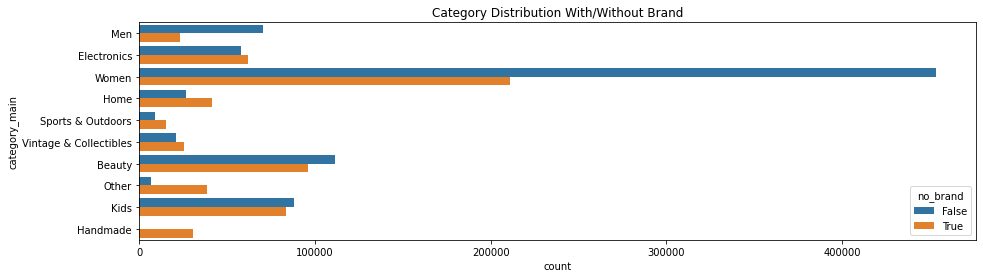

In [29]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y='category_main', hue='no_brand', data=train).set_title('Category Distribution With/Without Brand');
plt.show()

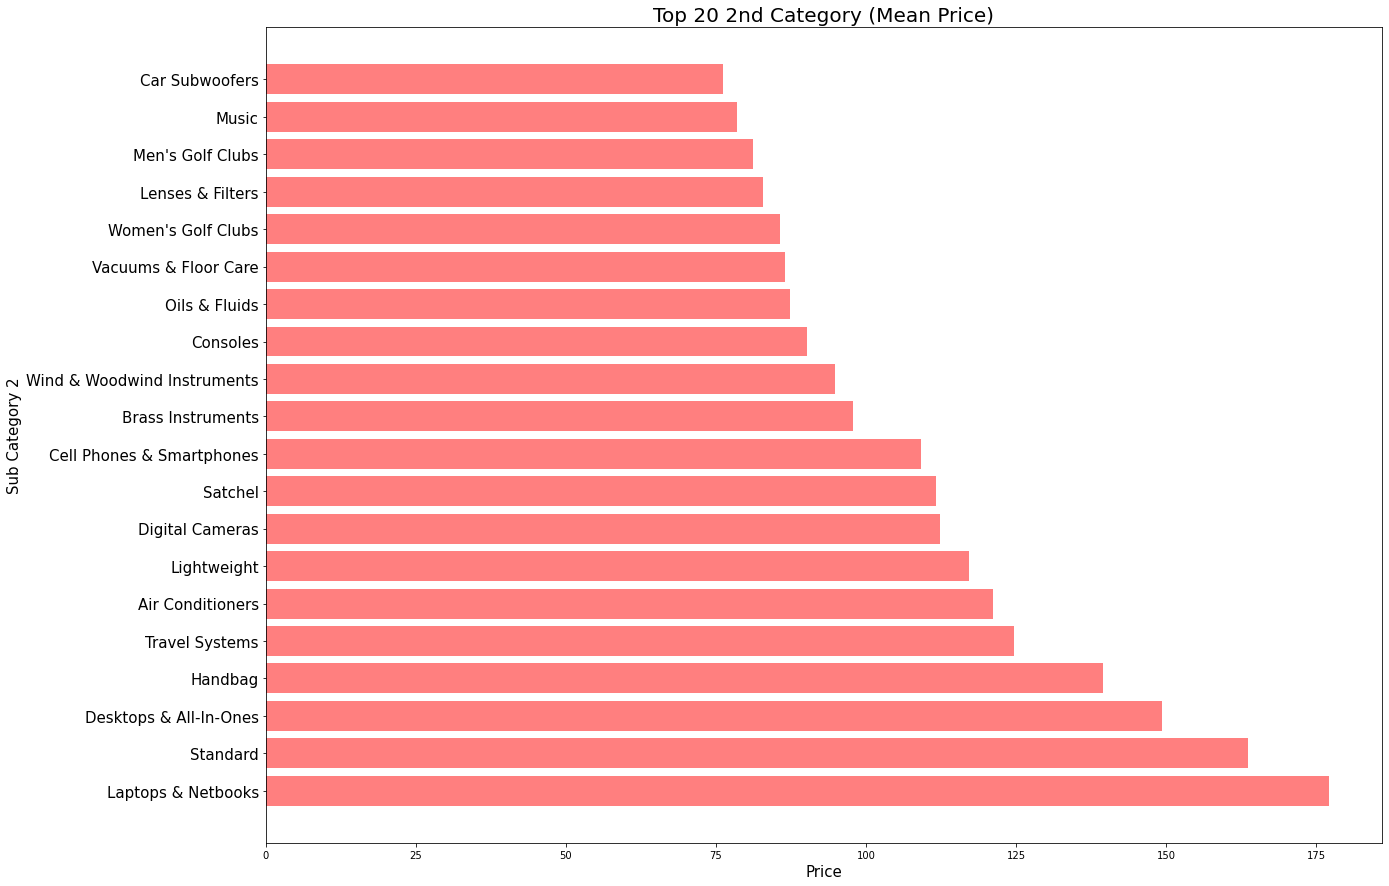

In [30]:
df = cat_train.groupby(['category_sub2'])['price'].agg(['mean']).reset_index().rename(columns={'index': 'main', 'category_main':'count'})
df= df.sort_values('mean', ascending=False).head(20)

plt.figure(figsize=(20, 15))
plt.barh(range(0,len(df)), df['mean'], align='center', alpha=0.5, color='r')
plt.yticks(range(0,len(df)), df['category_sub2'], fontsize=15)

plt.xlabel('Price', fontsize=15)
plt.ylabel('Sub Category 2', fontsize=15)
plt.title('Top 20 2nd Category (Mean Price)', fontsize=20)
plt.show()

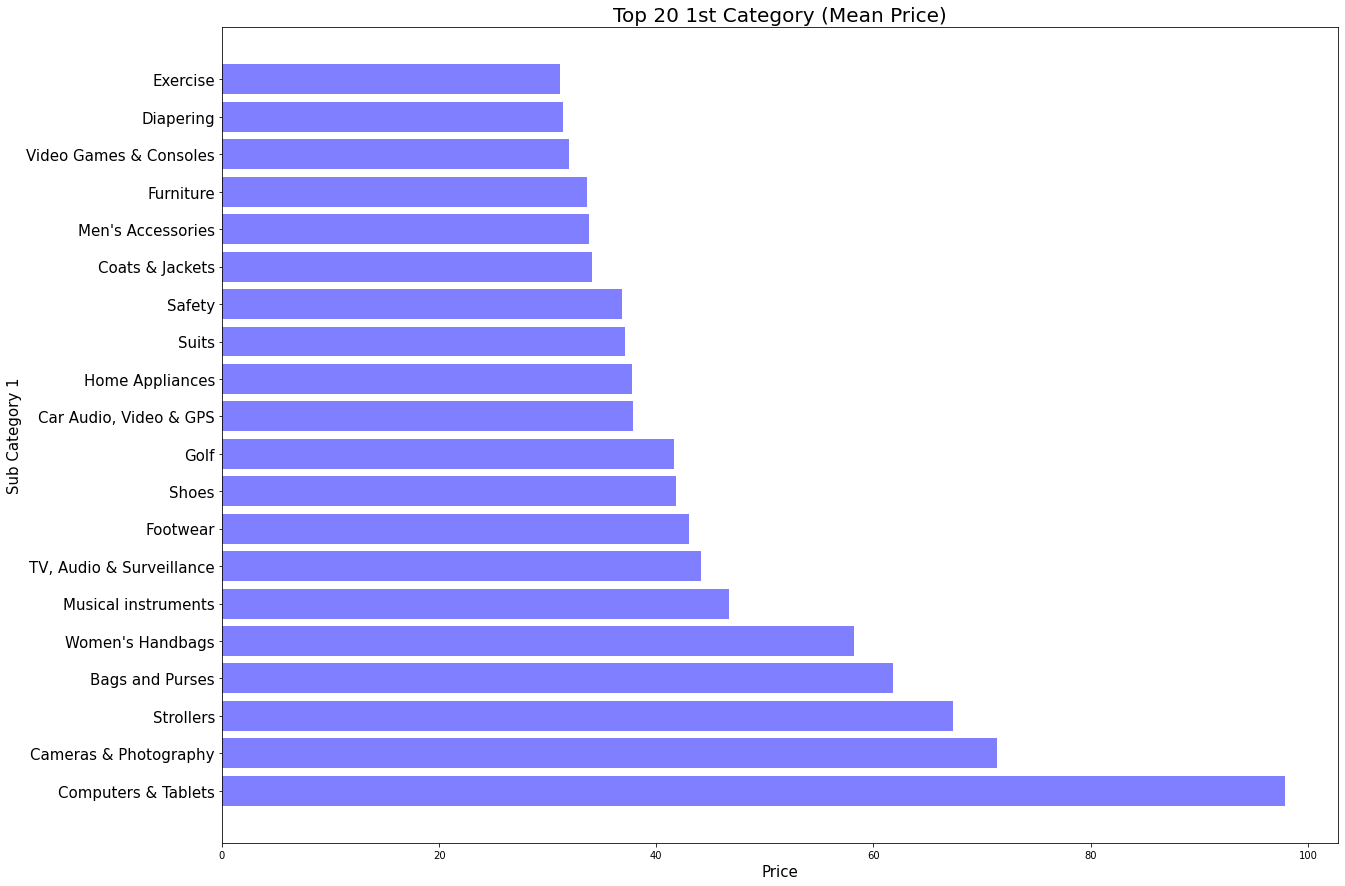

In [31]:
df = cat_train.groupby(['category_sub1'])['price'].agg(['mean']).reset_index().rename(columns={'index': 'main', 'category_main':'count'})
df= df.sort_values('mean', ascending=False)[0:20]

plt.figure(figsize=(20, 15))
plt.barh(range(0,len(df)), df['mean'], align='center', alpha=0.5, color='b')
plt.yticks(range(0,len(df)), df['category_sub1'], fontsize=15)

plt.xlabel('Price', fontsize=15)
plt.ylabel('Sub Category 1', fontsize=15)
plt.title('Top 20 1st Category (Mean Price)', fontsize=20)
plt.show()

In [32]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm import tqdm
import re
import collections
from wordcloud import STOPWORDS
from scipy.sparse import csr_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [33]:

train_data=pd.read_csv("/content/drive/MyDrive/CODECLAUSE INTERNSHIP/train.tsv", sep = '\t')
train_data.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [34]:

train_data = train_data[train_data['price'] > 0].reset_index(drop=True)
train_data,cv_data=train_test_split(train_data,test_size=0.1,random_state=42)
print(train_data.shape)
print(cv_data.shape)
     

(1333494, 8)
(148167, 8)


In [35]:

train=train_data.copy()
val=cv_data.copy()

In [36]:
def handle_category(data):
  """this function splits the category_name into further three sub_categories."""
  cat1=[]
  cat2=[]
  cat3=[]
  i=0
  for row in data:
    try:
      categories=row.split('/')
    except:
      categories=['','','']
    cat1.append(categories[0])
    cat2.append(categories[1])
    cat3.append(categories[2])
    i+=1
  return cat1,cat2,cat3
     

In [37]:
c1,c2,c3=handle_category(train_data['category_name'])
train_data['sub_category1']=c1
train_data['sub_category2']=c2
train_data['sub_category3']=c3
c1,c2,c3=handle_category(cv_data['category_name'])
cv_data['sub_category1']=c1
cv_data['sub_category2']=c2
cv_data['sub_category3']=c3
     

In [38]:

train_data['item_description'].fillna(value='No description given',inplace=True)
train_data['brand_name'].fillna(value='Not known',inplace=True)
train_data.isnull().sum()

train_id                0
name                    0
item_condition_id       0
category_name        5661
brand_name              0
price                   0
shipping                0
item_description        0
sub_category1           0
sub_category2           0
sub_category3           0
dtype: int64

In [39]:
cv_data['item_description'].fillna(value='No description given',inplace=True)
cv_data['brand_name'].fillna(value='Not known',inplace=True)
cv_data.isnull().sum()

train_id               0
name                   0
item_condition_id      0
category_name        653
brand_name             0
price                  0
shipping               0
item_description       0
sub_category1          0
sub_category2          0
sub_category3          0
dtype: int64

In [40]:

test_data=pd.read_csv("/content/drive/MyDrive/CODECLAUSE INTERNSHIP/test.tsv",sep="\t")
test_data.head(3)
test=test_data.copy()

In [41]:

c1,c2,c3=handle_category(test_data['category_name'])
test_data['sub_category1']=c1
test_data['sub_category2']=c2
test_data['sub_category3']=c3

In [42]:
test_data['brand_name'].fillna(value='Not known',inplace=True)
test_data['item_description'].fillna(value='No description given',inplace=True)
test_data.isnull().sum()

test_id                 0
name                    0
item_condition_id       0
category_name        3058
brand_name              0
shipping                0
item_description        0
sub_category1           0
sub_category2           0
sub_category3           0
dtype: int64

Number of Unique Category1: 11


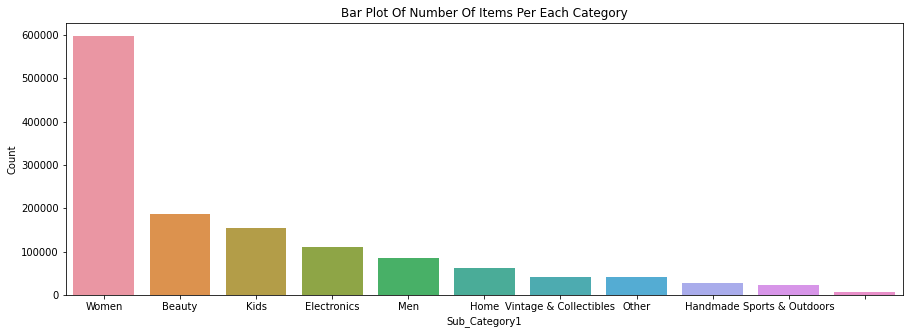

In [43]:

count=train_data['sub_category1'].value_counts()
print("Number of Unique Category1: {}".format(len(count)))
plt.figure(figsize=(15,5))
sns.barplot(count.index,count)
plt.title("Bar Plot Of Number Of Items Per Each Category")
plt.xlabel('Sub_Category1')
plt.ylabel('Count')
plt.show()
     

Number Of Unique Category2: 114


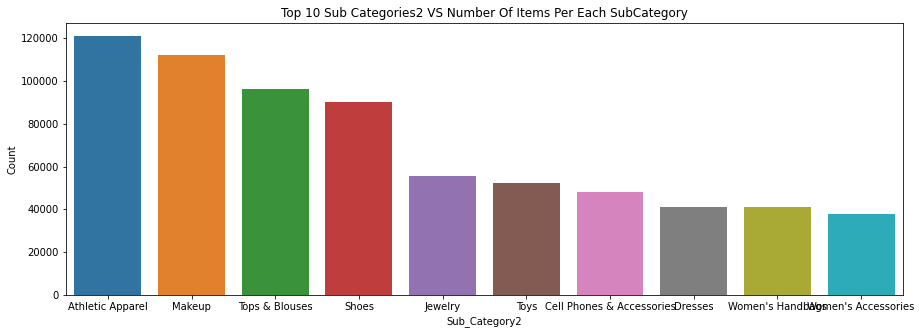

In [44]:

count=train_data['sub_category2'].value_counts()
print("Number Of Unique Category2: {}".format(len(count)))
plt.figure(figsize=(15,5))
sns.barplot(count.index[:10],count[:10])
plt.xlabel('Sub_Category2')
plt.ylabel('Count')
plt.title("Top 10 Sub Categories2 VS Number Of Items Per Each SubCategory")
plt.show()
     

Number Of Unique Category3: 869


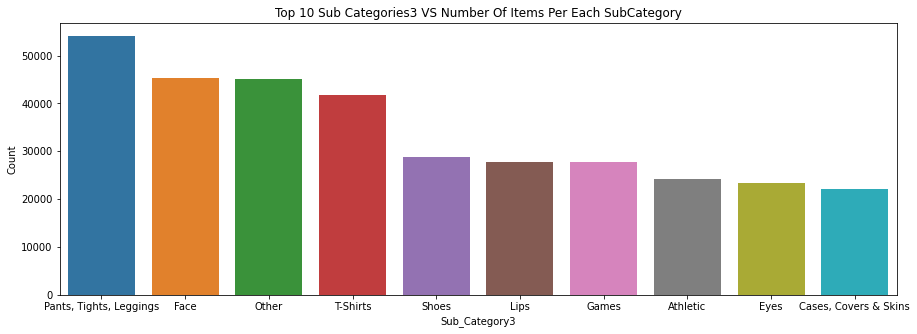

In [45]:
count=train_data['sub_category3'].value_counts()
print("Number Of Unique Category3: {}".format(len(count)))
plt.figure(figsize=(15,5))
sns.barplot(count.index[:10],count[:10])
plt.xlabel('Sub_Category3')
plt.ylabel('Count')
plt.title("Top 10 Sub Categories3 VS Number Of Items Per Each SubCategory")
plt.show()

Number of Unique Brands: 4674


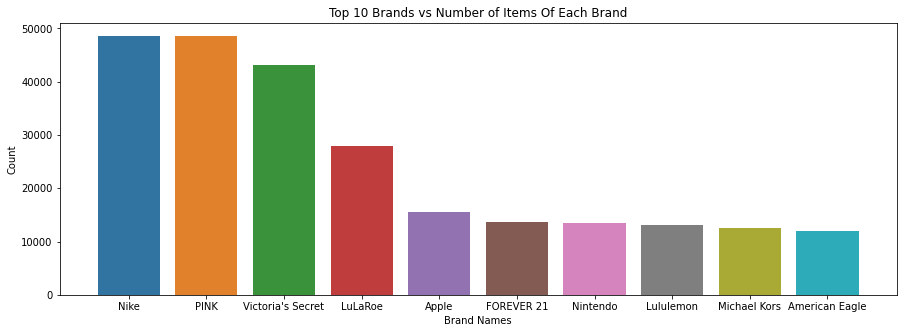

In [46]:
unique_brands=train_data['brand_name'].value_counts()
print("Number of Unique Brands: {}".format(len(unique_brands)))
plt.figure(figsize=(15,5))
sns.barplot(unique_brands.index[1:11],unique_brands[1:11])
plt.title('Top 10 Brands vs Number of Items Of Each Brand')
plt.xlabel('Brand Names')
plt.ylabel('Count')
plt.plot()
plt.show()

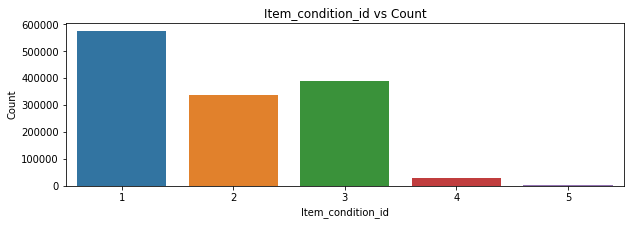

In [47]:
count=train_data['item_condition_id'].value_counts()
plt.figure(figsize=(10,3))
sns.barplot(count.index[:10],count[:10])
plt.title('Item_condition_id vs Count')
plt.xlabel('Item_condition_id')
plt.ylabel('Count')
plt.show()

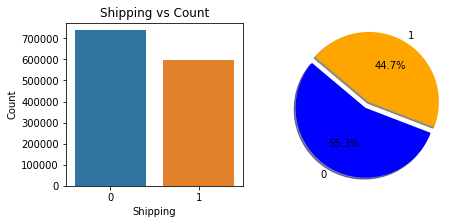

In [48]:

count=train_data['shipping'].value_counts()
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
sns.barplot(count.index,count)
plt.xlabel('Shipping')
plt.ylabel('Count')
plt.title('Shipping vs Count')
plt.subplot(1,2,2)
labels = ['0','1']
sizes = count
colors = ['blue','orange']
explode = (0.1, 0)  # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

In [49]:

train_data['price'].describe()

count    1.333494e+06
mean     2.675457e+01
std      3.866316e+01
min      3.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

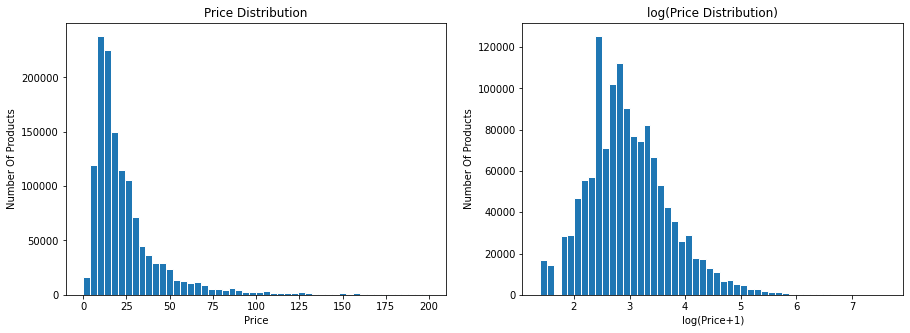

In [50]:

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(train_data['price'],bins=50,range=[0,200],edgecolor='white')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel("Number Of Products")
plt.subplot(1,2,2)
log_price=[np.log(i+1) for i in train_data['price']]
plt.hist(np.log(train_data['price']+1),bins=50,edgecolor='white')
plt.title("log(Price Distribution)")
plt.xlabel("log(Price+1)")
plt.ylabel("Number Of Products")
plt.show()

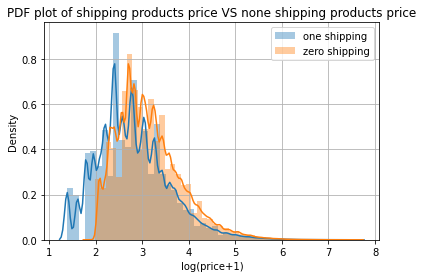

In [51]:
one_shipping=np.log(train_data.loc[train_data['shipping']==1,'price']+1)
zero_shipping=np.log(train_data.loc[train_data['shipping']==0,'price']+1)
sns.distplot(one_shipping,label='one shipping')
sns.distplot(zero_shipping,label='zero shipping')
plt.title('PDF plot of shipping products price VS none shipping products price')
plt.xlabel("log(price+1)")
plt.grid()
plt.legend()
plt.show()

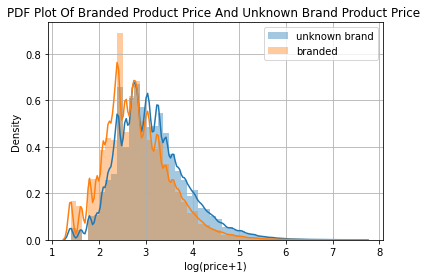

In [52]:
unknown_brand=np.log(train_data.loc[train_data['brand_name']!='Not known','price']+1)
brand=np.log(train_data.loc[train_data['brand_name']=='Not known','price']+1)
sns.distplot(unknown_brand,label='unknown brand')
sns.distplot(brand,label='branded')
plt.title('PDF Plot Of Branded Product Price And Unknown Brand Product Price ')
plt.xlabel('log(price+1)')
plt.grid()
plt.legend()
plt.show()

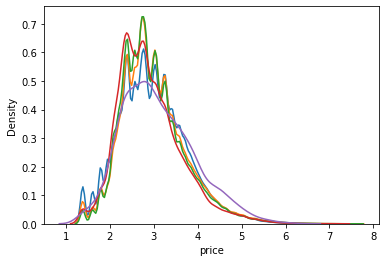

In [53]:
id1=np.log(train_data.loc[train_data['item_condition_id']==1,'price']+1)
id2=np.log(train_data.loc[train_data['item_condition_id']==2,'price']+1)
id3=np.log(train_data.loc[train_data['item_condition_id']==3,'price']+1)
id4=np.log(train_data.loc[train_data['item_condition_id']==4,'price']+1)
id5=np.log(train_data.loc[train_data['item_condition_id']==5,'price']+1)
sns.distplot(id1,hist=False,label='item_condition_id=1')
sns.distplot(id2,hist=False,label='item_condition_id=2')
sns.distplot(id3,hist=False,label='item_condition_id=3')
sns.distplot(id4,hist=False,label='item_condition_id=4')
sns.distplot(id5,hist=False,label='item_condition_id=5')
plt.show()

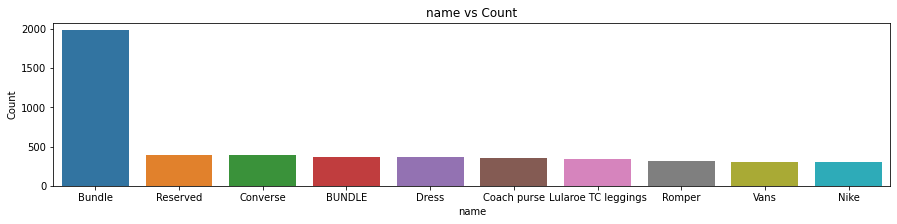

In [54]:

count=train_data['name'].value_counts()
plt.figure(figsize=(15,3))
sns.barplot(count.index[:10],count[:10])
plt.title('name vs Count')
plt.xlabel('name')
plt.ylabel('Count')
plt.show()

In [55]:
stopwords=set(stopwords.words('english'))

In [56]:

def stopwords_count(data):
  """this function counts the number of stopwords in each of the item_description"""
  count_stopwords=[]
  for i in tqdm(data['item_description']):
    count=0
    for j in i.split(' '):
      if j in stopwords: count+=1  #finding if the word is present in the nltk stopwords or not
    count_stopwords.append(count)
  return count_stopwords

In [57]:
train_data['count_stopwords']=stopwords_count(train_data)
cv_data['count_stopwords']=stopwords_count(cv_data)
test_data['count_stopwords']=stopwords_count(test_data)

100%|██████████| 693359/693359 [00:03<00:00, 194797.97it/s]


In [58]:
train_data['count_stopwords'].describe()
     

count    1.333494e+06
mean     5.982603e+00
std      9.063958e+00
min      0.000000e+00
25%      0.000000e+00
50%      3.000000e+00
75%      8.000000e+00
max      1.180000e+02
Name: count_stopwords, dtype: float64

In [59]:

# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    """this function removies shorthands for the textual data..."""
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [60]:

# https://gist.github.com/sebleier/554280
def text_preprocessing(data):
  """this function performs preprocessing the item_description """
  preprocessed_total = []
  for sentance in tqdm(data['item_description'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\r', ' ')
    sent = sent.replace('\"', ' ')
    sent = sent.replace('\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)  #removing stop words
    preprocessed_total.append(sent.lower().strip())
  return preprocessed_total

In [61]:
train_data['item_description']=text_preprocessing(train_data)
cv_data['item_description']=text_preprocessing(cv_data)
test_data['item_description']=text_preprocessing(test_data)

100%|██████████| 693359/693359 [00:19<00:00, 35786.92it/s]


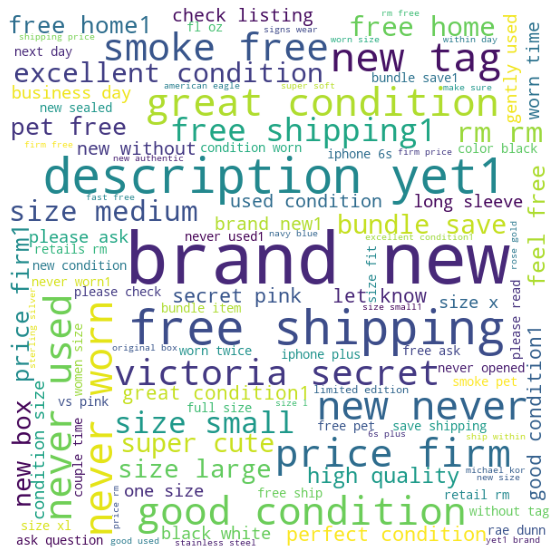

In [62]:
stopwords=set(STOPWORDS)
word_cloud = WordCloud(width = 600, height = 600,background_color ='white', stopwords=stopwords,min_font_size = 10).generate("1 ".join(train_data['item_description']))
plt.figure(figsize = (15, 10))
plt.imshow(word_cloud)
plt.axis('off')                                             
plt.show()
     

In [63]:

word_count={}
for sentence in tqdm(train_data['item_description']):
    for word in sentence.split(' '):
        if len(word)>=3:  #taking words which are of length>=3
            if word not in word_count:
                word_count[word]=1  #if word not present in dict assigning it to 1
            else:
                word_count[word]+=1 #else incrementing it by 1

100%|██████████| 1333494/1333494 [00:18<00:00, 73433.53it/s] 


In [64]:
n_print=25
word_counter = collections.Counter(word_count)
words=[]
counter=[]
for word, count in word_counter.most_common(n_print):
    words.append(word)
    counter.append(count)

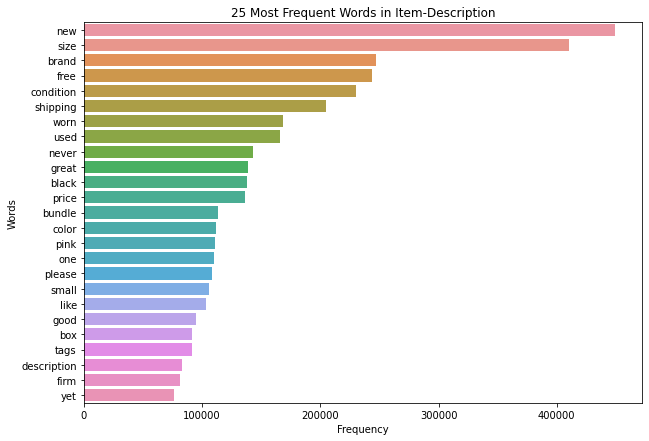

In [65]:
plt.figure(figsize=(10,7))
sns.barplot(counter,words)
plt.title("25 Most Frequent Words in Item-Description")
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

In [66]:
def sentiment_analysis(data):
   """this function performs sentiment score analysis of each datapoint"""
   sentiment_score = SentimentIntensityAnalyzer()
   sentiment = []
   for sentence in tqdm(data):
       sentiment.append(sentiment_score.polarity_scores(sentence))
   return sentiment

In [67]:
training_sentiment_score=sentiment_analysis(train_data['item_description']) 
cv_sentiment_score=sentiment_analysis(cv_data['item_description'])
testing_sentiment_score=sentiment_analysis(test_data['item_description'])
     

100%|██████████| 693359/693359 [03:01<00:00, 3810.72it/s]


In [68]:
def splitting_sentiment(sentiment_score):
  """this function splits sentiment analysis score into four further features ie positive,negative,compound and neutral"""
  positive=[]
  negative=[]
  neutral=[]
  compound=[]
  for i in sentiment_score:
    positive.append(i['pos'])
    negative.append(i['neg'])
    neutral.append(i['neu'])
    compound.append(i['compound'])
  return positive,negative,neutral,compound

In [69]:
print("Training Data Sentiment Analysis: ")
pos,neg,neu,comp=splitting_sentiment(training_sentiment_score)
train_data['positive']=pos
train_data['negative']=neg
train_data['neutral']=neu
train_data['compound']=comp
print(train_data.iloc[50]['item_description'])
print(training_sentiment_score[50])
     

Training Data Sentiment Analysis: 
american flag bodysuit two buttons bottom size large fits like medium brand tobi
{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'compound': 0.3612}


In [70]:
print("CV Data Sentiment Analysis: ")
pos,neg,neu,comp=splitting_sentiment(cv_sentiment_score)
cv_data['positive']=pos
cv_data['negative']=neg
cv_data['neutral']=neu
cv_data['compound']=comp
print(cv_data.iloc[50]['item_description'])
print(cv_sentiment_score[50])

CV Data Sentiment Analysis: 
brand new
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [71]:

print("Testing Data Sentiment Analysis: ")
pos,neg,neu,comp=splitting_sentiment(testing_sentiment_score)
test_data['positive']=pos
test_data['negative']=neg
test_data['neutral']=neu
test_data['compound']=comp
print(test_data.iloc[50]['item_description'])
print(testing_sentiment_score[50])

Testing Data Sentiment Analysis: 
pok mon card
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
